In [65]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/MIA_Final_Project'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MIA_Final_Project


In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import interpolate
import scipy.misc
import scipy.signal
from matplotlib import cm
import math
from PIL import Image
import pandas as pd
from numpy.fft import fft2, fftshift, ifftshift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

In [67]:
def load_gif(filepath):
    pil_image = Image.open(filepath)
    frames = []
    try:
        while True:
            frame = pil_image.convert('L')  # Convert to grayscale
            frame_np = np.array(frame)
            frames.append(frame_np)
            pil_image.seek(pil_image.tell() + 1)
    except EOFError:
        pass
    return frames

# Load the dataset
dataset = {
    "apple": [load_gif(f'original/apple-{i}.gif') for i in range(1,21)],
    "bone":[load_gif(f'original/Bone-{i}.gif') for i in range(1,21)],
    "key":[load_gif(f'original/key-{i}.gif') for i in range(1,21)],
    "personal_car":[load_gif(f'original/personal_car-{i}.gif') for i in range(1,21)],
    "spoon":[load_gif(f'original/spoon-{i}.gif') for i in range(1,21)],
    "tree":[load_gif(f'original/tree-{i}.gif') for i in range(1,21)],
    "watch":[load_gif(f'original/watch-{i}.gif') for i in range(1,21)],
}

In [68]:
def plot_descriptors(d):
  # Inverse Fourier Transform to get back contour points
  reconstructed_contour = np.fft.ifft(d)
  # Extract the real and imaginary parts to plot
  x_reconstructed = reconstructed_contour.real
  y_reconstructed = reconstructed_contour.imag
  plt.figure(figsize=(5, 5))
  plt.plot(x_reconstructed, -1*y_reconstructed, 'r-', label='Reconstructed Contour')
  plt.title('Reconstructed Contour from Phase')
  plt.axis('equal')
  plt.show()

In [69]:
def find_contour(image):
  '''
  Calculate contour of image, then translated and scale
  Input parameter: image as a 2D ndarray
  Returns: an Nx1 array of the scaled and translated contour, where
           each contour is stored as Z = x + j * y
  Returns: a, fourier coefficients
  '''

  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  largest_contour = max(contours, key=cv2.contourArea)
  # reshape the contour into a Nx2 array
  P = largest_contour.reshape(largest_contour.shape[0], largest_contour.shape[-1])
  Z = P[:,0] + 1j*P[:,1]
  Zc = np.mean(Z)
  # a = np.fft.fft(Z)
  a = np.zeros_like(Z)*1j
  N = Z.shape[0]
  for k in range(N):
    sum = 0
    for n in range(N):
      sum += Z[n] * np.exp(-1j*2*np.pi*n*k/N)
    a[k] = sum/N

  Sc = np.sum( np.abs(a[1:]) )
  return (Z - Zc) / Sc, a, Sc

def sort_coef(a, M=30):
  '''
  Step 2 of the algorithm: assume we don't sort
  Inputs: Fourier coefficients and number of fourier coefficients we want to keep
  Return: R_ind, a list of the first R largest coefficients
  '''
  a = np.abs(a[1:])
  am = np.concatenate((a[-M//2:], a[1:M//2+1]))
  M_ind = am.argsort()[::-1]
  # M_ind = M_ind[:M]
  M_ind = np.concatenate((M_ind[-M//2:], M_ind[1:M//2+1]))
  am = a[M_ind]
  target = .95 * np.sum(am)
  R = []
  current_sum = 0

  for index in M_ind:
      current_sum += am[index]
      R.append(index)
      if current_sum > target:
          break

  return np.array(R)

# step 3 and step 4
def derotate_all_contours(Z, a, Sc,M=30):
  '''
  Input: Nx1 array of the contour, assume we don't actually sort
  Input: a_M, a list
  Output: NxN array of the contour, calculated using each point as the starting point
  Output: NxM array of coefficient
  Output : a0
  '''
  N = Z.shape[0]
  contours = np.ones((N, N))*1j
  coefficients = np.ones((N, M))*1j
  ang = np.angle(Z[0])

  contours[0, :] = np.exp(-1j * ang) * Z
  a0 = np.exp(-1j * ang) * Sc * a
  coefficients[0, :] = np.concatenate((a0[-M//2:], a0[1:M//2+1]))
  for m in range(1, N):
    c = []
    Zm = np.concatenate((Z[m:], Z[:m]))
    ang_m = np.angle(Zm[0])
    Z = np.exp(-1j * ang_m) * Zm
    contours[m, :] = Z
    for k in range(-M//2, M//2+1):
      if k == 0:
        continue
      else:
        c.append(np.exp(-1j * ang_m) * np.exp(2j*np.pi*m*k/N) * np.exp(1j *ang) * a0[k])
    coefficients[m,:] = np.array(c).T
  return contours, coefficients, a0

 # step 5
def objective_function(coefficients, R_ind):
  '''
  Input:
          coefficients: A 2D array where each row contains complex coefficient
          R_ind : An array of indices specifying which coefficients in each row should be considered in the summation.

  Output: f[m]
  '''
  f = np.ones((coefficients.shape[0], 1))
  for m in range(coefficients.shape[0]):
    am = coefficients[m, :]
    f[m] = 2 * np.sum( np.abs( np.imag(am[R_ind])) )
  return f


In [70]:
# step 6 and 7
def sort_points_and_find_local_minima(fm, Q = 6):
  '''
  sort pairs (m, f(m)) in ascending order
  return: Q best local minima
  '''
  local_minima = []
  for i in range(1, len(fm)-1):
    if fm[i - 1] > fm[i] and fm[i] < fm[i + 1]:
      local_minima.append((fm[i][0], i))

  sorted_lm = sorted(local_minima)
  lm = np.array(sorted_lm)
  val = min(Q, len(local_minima))
  lm = lm[:val, :]

  return lm[:, 1]

In [71]:
# step 8 and 9
def interpolate_phase_function(lm_index, Z, a0, N, R_ind, Q = 6, M = 30, S=1, delta_m = 0.05):
    '''
    compute finer pseudomirrror points
    return: new coefficients, ms_fine: 1D array (best Q local minima)
    '''
    arg_Z0 = np.angle(Z[0])
    coefficients = np.ones((N, M), dtype=np.complex128)

    for lm_idx in lm_index:
        x = np.arange(lm_idx - S, lm_idx + S + delta_m, delta_m)
        y = np.angle(Z[x.astype(int)])
        g = interpolate.interp1d(x, y, kind='linear', fill_value='extrapolate')

    for m in range(1, N):
      c = []
      Zm = np.concatenate((Z[m:], Z[:m]))
      ang_m = np.angle(Zm[0])
      for k in range(-M//2, M//2+1):
        if k == 0:
            continue
        else:
          c.append(np.exp(-1j * g(m)) * np.exp(2j*np.pi*m*k/N) * \
              np.exp(1j * arg_Z0) * a0[k])
      coefficients[m,:] = np.array(c).T

    f = objective_function(coefficients, R_ind)
    ms_fine = sort_points_and_find_local_minima(f)

    return coefficients, ms_fine

In [72]:
# step 10
def get_pifd_descriptors(coefficients, ms_fine_index):
  descriptors = []
  for i in ms_fine_index:
    descriptors.append(coefficients[i])
  return np.array(descriptors)

In [73]:
# aggregate all previous steps
def find_pifd(image, Q, M):
  Z, a, Sc = find_contour(image)
  R = sort_coef(a, M)
  new_Z, new_a, a0 = derotate_all_contours(Z, a, Sc,M)
  N = Z.shape[0]
  f = objective_function(new_a, R)
  lm = sort_points_and_find_local_minima(f, Q)
  lm_index = np.array([int(i) for i in lm])
  coefficients, ms_fine = interpolate_phase_function(lm_index, Z, a0, N, R, M , S=1, delta_m = 0.05)
  ms_fine_index = np.array([int(i) for i in ms_fine])
  pifd = get_pifd_descriptors(coefficients, ms_fine_index)
  return pifd

In [75]:
# ML:
from sklearn.model_selection import train_test_split

# Step 1: Compute PIFD for each image and store them along with their labels
X = []  # PIFD data
y = []  # Labels
for label, image in dataset.items():
    for i in range(len(image)):
      pifd = find_pifd(image[i][0], M=30, Q=4)
      X.append(pifd)
      y.append(label)


In [76]:
# turning X and y into ndarrays
X = np.array(X, dtype='object')
y = np.array(y)
new_X = np.vstack(X)
new_y = []
for i in range(len(X)):
  s = X[i].shape[0]
  new_y.extend(np.repeat(y[i], s))
new_y = np.array(new_y)

In [77]:
# Define a function to pad or truncate the arrays
def pad_array(arr, target_length=2000, pad_value=0):
    if len(arr) > target_length:
        return arr[:target_length]  # Truncate if the array is too long
    else:
        return np.pad(arr, (0, target_length - len(arr)), 'constant', constant_values=(pad_value,))  # Pad if the array is too short

# prepare dataset for based on their original contour and fourier descriptor
iX = []
ia = []
iy = []
for label, images in dataset.items():
    for image in images:
        try:
            Z, a, _ = find_contour(image[0])
            Z_padded = pad_array(Z)
            iX.append(Z_padded)
            a = np.concatenate((a[-15:], a[1:16]))
            ia.append(a)
            iy.append(label)
        except Exception as e:
            print(f"Failed to process image with label {label}: {e}")
            continue

# Convert lists to numpy arrays
imX = np.array(iX)
imA = np.array(ia)
imy = np.array(iy)


In [78]:
X_real1 = np.hstack(((new_X.astype(complex)).real, (new_X.astype(complex)).imag)) # creates feature data from PIFD
X_real2 = np.hstack((imX.real, imX.imag)) # creates feature data from Z, image contours
X_real3 = np.hstack((imA.real, imA.imag)) # creates feature data from a, fourier descriptors

In [79]:
def rf_summary(X, y, s = 42):
  # Standardize features
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=s)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Train a classifier
  clf = RandomForestClassifier(n_estimators=75, random_state=42)
  clf.fit(X_train, y_train)

  # Evaluate the classifier
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  return X_train, X_test, y_train, y_test, clf

In [80]:
def plot_heatmap(clf, y_train, X_test, y_test):
  # Predict labels for the test set
  y_pred = clf.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)

  # Calculate the percentage of data the model got right for each true class
  cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

  # Display confusion matrix as a heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=sorted(set(y_train)), yticklabels=sorted(set(y_train)))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix (Percentage)')
  plt.show()


In [81]:
def accuracy_bar(clf, X_test, y_test):
  # Calculate accuracy for each class
  y_pred = clf.predict(X_test)
  class_labels = np.unique(y_test)
  accuracies = []

  for i in range(len(class_labels)):
      class_idx = (y_test == class_labels[i])
      correct_predictions = (y_test[class_idx] == y_pred[class_idx]).sum()
      total_samples = class_idx.sum()
      accuracy = correct_predictions / total_samples
      accuracies.append(accuracy)

  # Create a DataFrame with class labels and accuracies
  data = {"Class": class_labels, "Accuracy": accuracies}
  df = pd.DataFrame(data)

  # Plot the bar graph
  plt.figure(figsize=(8, 6))
  sns.barplot(x="Class", y="Accuracy", data=df, palette="viridis")
  plt.title("Accuracy of Each Class")
  plt.xlabel("Class")
  plt.ylabel("Accuracy")
  plt.ylim(0, 1.1)  # Set y-axis limit to ensure accuracy is between 0 and 1
  plt.show()


In [158]:
def roc(clf, y_train, X_test, y_test):

  # Make predictions on the testing data
  y_score = clf.predict_proba(X_test)

  # Binarize the labels for ROC computation
  y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(np.unique(y_train))):
      fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot ROC curve for each class
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})', color='deeppink', linestyle=':', linewidth=4)

  for i, class_name in enumerate(np.unique(y_train)):
      plt.plot(fpr[i], tpr[i], label=f'{class_name}: ROC curve (AUC = {roc_auc[i]:0.2f})')

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()

In [190]:
def pr_curve(clf, X_test, y_test):
  # Compute precision-recall curve and precision-recall area for each class
  # Make predictions on the testing data
  y_score = clf.predict_proba(X_test)
  # Binarize the labels
  y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

  precision = dict()
  recall = dict()
  pr_auc = dict()
  for i, class_name in enumerate(np.unique(y_test)):
      precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
      pr_auc[i] = auc(np.sort(precision[i]), np.sort(recall[i]))

  # Plot precision-recall curve for each class
  plt.figure()
  for i, class_name in enumerate(np.unique(y_test)):

    plt.plot(recall[i], precision[i], label=f'{class_name} (AUC = {pr_auc[i]:0.2f})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower left")
  plt.show()


              precision    recall  f1-score   support

       apple       1.00      0.97      0.98        29
        bone       0.86      1.00      0.93        19
         key       1.00      0.93      0.96        27
personal_car       0.88      0.84      0.86        25
       spoon       1.00      1.00      1.00        19
        tree       0.91      0.91      0.91        23
       watch       0.85      0.88      0.87        26

    accuracy                           0.93       168
   macro avg       0.93      0.93      0.93       168
weighted avg       0.93      0.93      0.93       168



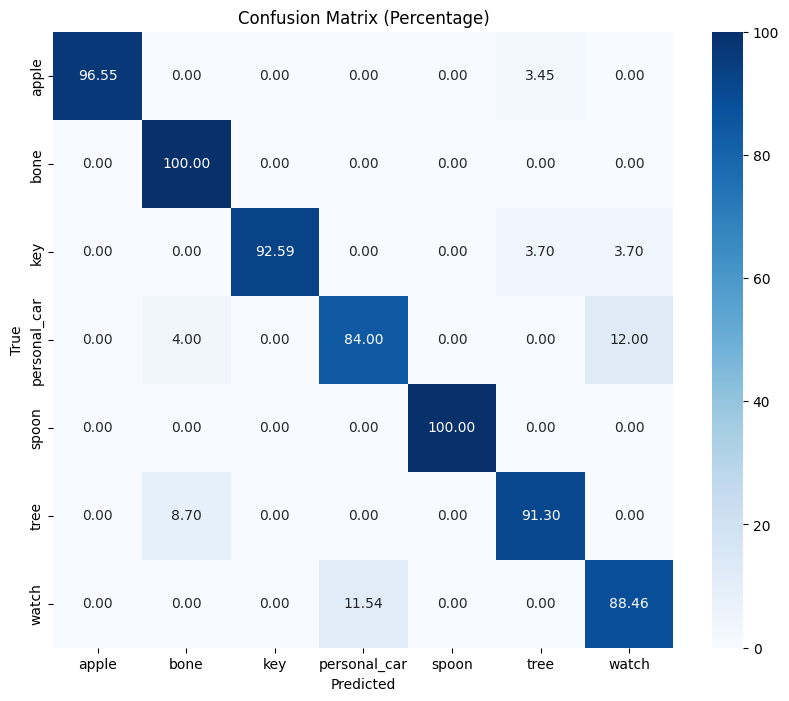

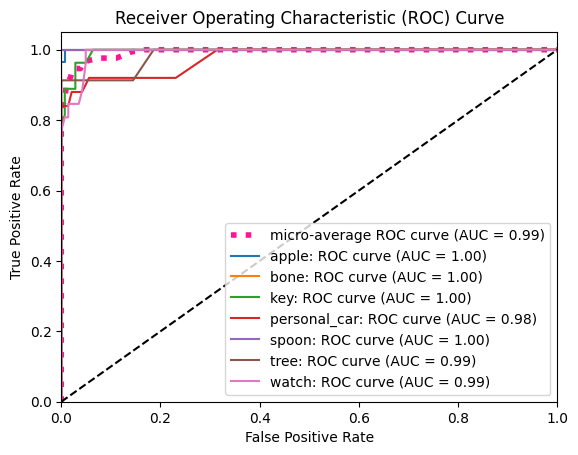

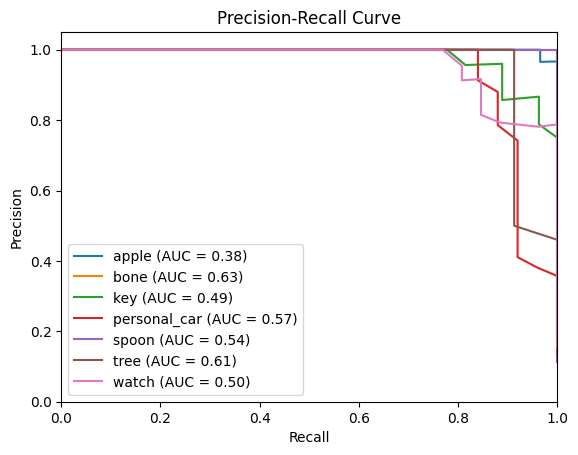

In [88]:
# all metrics for PIFD
X_train, X_test, y_train, y_test, clf = rf_summary(X_real1, new_y)

plot_heatmap(clf, y_train, X_test, y_test)

roc(clf, X_test, y_test)

pr_curve(clf, X_test, y_test)

              precision    recall  f1-score   support

       apple       0.80      1.00      0.89         4
        bone       0.67      1.00      0.80         4
         key       1.00      1.00      1.00         2
personal_car       0.83      1.00      0.91         5
       spoon       0.50      0.50      0.50         2
        tree       0.80      0.57      0.67         7
       watch       1.00      0.50      0.67         4

    accuracy                           0.79        28
   macro avg       0.80      0.80      0.78        28
weighted avg       0.81      0.79      0.77        28



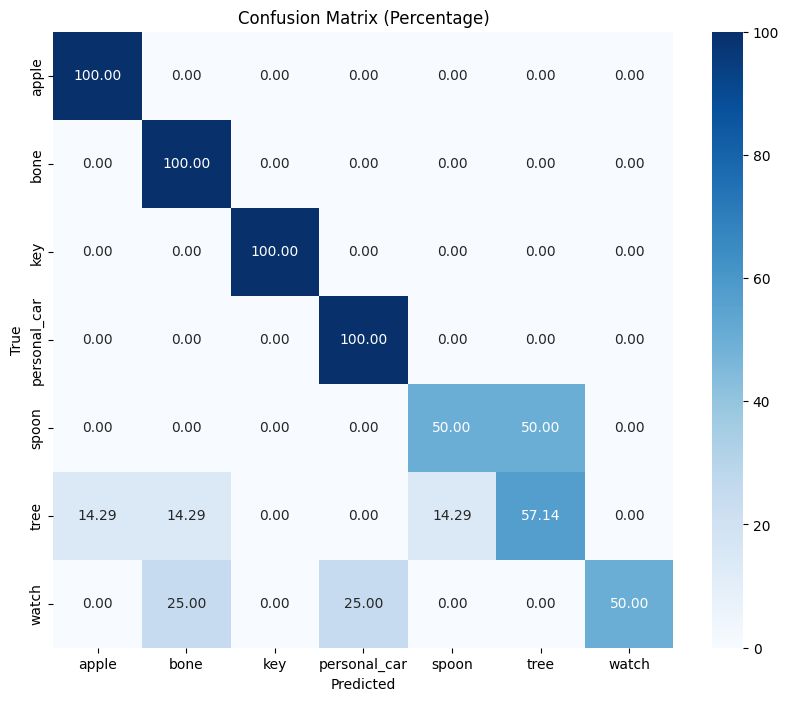

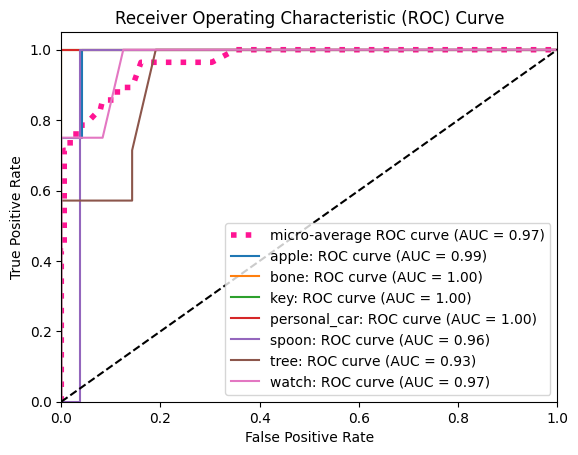

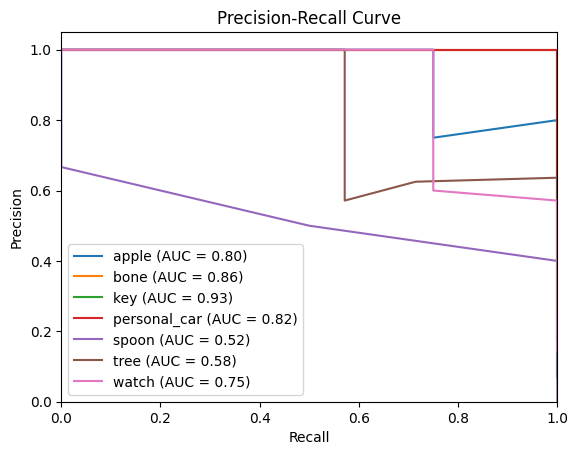

In [147]:
# result on image contour

X_train, X_test, y_train, y_test, clf = rf_summary(X_real2, imy)

plot_heatmap(clf, y_train, X_test, y_test)

roc(clf, X_test, y_test)

pr_curve(clf, X_test, y_test)

              precision    recall  f1-score   support

       apple       0.67      1.00      0.80         2
        bone       1.00      1.00      1.00         4
         key       0.00      0.00      0.00         1
personal_car       0.80      0.80      0.80         5
       spoon       1.00      1.00      1.00         3
        tree       1.00      1.00      1.00         4
       watch       1.00      0.78      0.88         9

    accuracy                           0.86        28
   macro avg       0.78      0.80      0.78        28
weighted avg       0.90      0.86      0.87        28



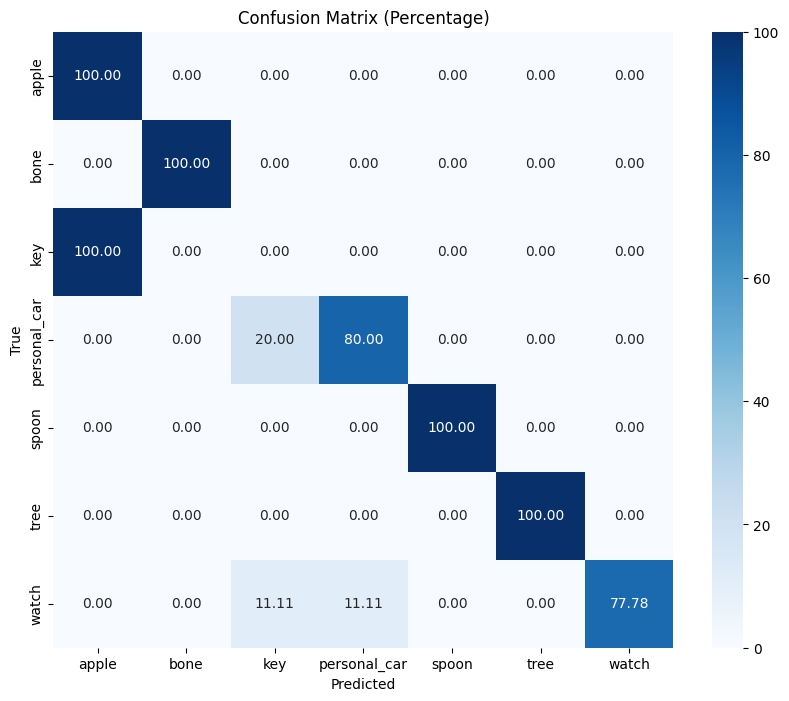

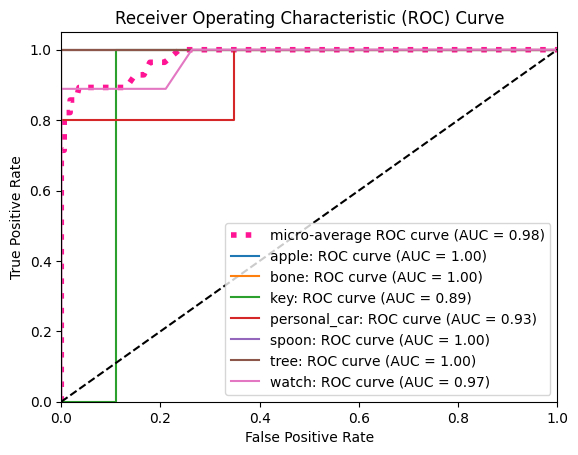

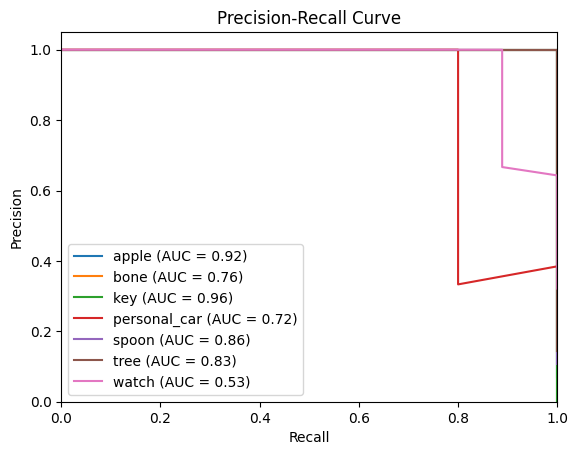

In [191]:
# result on traditional Fourier Descriptor

X_train, X_test, y_train, y_test, clf = rf_summary(X_real3, imy,33)

plot_heatmap(clf, y_train, X_test, y_test)

roc(clf, y_train, X_test, y_test)

pr_curve(clf, X_test, y_test)